In [5]:
%load_ext autoreload
%autoreload 2

from lightning_trainable.launcher.grid import GridLauncher
import numpy as np
import torch
import matplotlib.pyplot as plt
import mlae.evaluate as ev
import pandas as pd
import pathlib
from yaml import full_load
import seaborn as sns
from glob import glob

# Create data

Runs a grid of experiments with reconstruction weight $\beta \in [0.01, 100]$ and gaussian noise added to the data points on the sinusoid manifold with sd $\in {0.1, 0.2, 0.3}$. To run the same grid as in the paper, uncomment the two lower rows. Else, a smaller grid is run.

In [11]:
rc_levels = [0.01, 0.1, 1,10,100]
noise_levels = [0.1, 0.2]

# rc_levels = [0.01,0.05,0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10,100]
# noise_levels = [0.1, 0.2, 0.3]

In [ ]:
launcher = GridLauncher()
configs = launcher.grid_spec_to_list([
    ["../configs/toy.yaml"],
    ["../configs/surrogate.yaml"],
    *{
        "optimizer.lr": 0.001,
        "max_epochs": 50,
        "data_set": {
            "name": "sine"
        },
        "noise": noise_levels * 3,
        "models": [[{
            "name": "mlae.model.ResNet",
            "layers_spec": [[
                256,
                256,
                256,
                256
            ]],
            "latent_dim": 1
        }]],
        "loss_weights": [{
            "noisy_reconstruction": rc,
            "nll": 1.
        } for rc in rc_levels]
    }.items()
])

launcher.run_configs_and_wait(
    configs, verbose=True, num_parallel_runs=7, num_threads=1,
    cli_args=[
        "--name", "{data_set[name]},rc:{loss_weights[noisy_reconstruction]},noise:{noise}",
    ],
)

## Analyse experiments

In [8]:
def get_data_batch(noise, N=128):
    x1 = np.random.default_rng(12479).normal(size=N)
    x2 = np.sin(x1 * np.pi / 2)
    x0 = torch.from_numpy(np.stack((x1, x2), 1)).float()
    data_noise = torch.randn_like(x0) * noise
    return x0 + data_noise

def generate_query_string(filter_dict: dict, exact=False):
    query_strings = []
    temp = ''
    for key in filter_dict.keys():
        temp = '('
        if exact:
            selection_strings = ['(%s == %s)' %(str(key), v) for v in filter_dict[key]]
            temp += ' | '.join(selection_strings)
        else:
            selection_strings = ['(%s < %s & %s > %s )' %(str(key), v+0.00001, str(key), v-0.00001) for v in filter_dict[key]]
            temp += ' | '.join(selection_strings)
        temp += ')'
        query_strings.append(temp)

    query_string = ' & '.join(query_strings)

    return query_string

from typing import List

def generate_grid(df, reconstruction_weights: List, noise: List, plot_versions: List, switch_axis=False, generate_axis=True, row_height=4, col_width=5):
    filtered_versions = df[df['version_number'].isin(plot_versions)]

    filter_dict = {
        'reconstruction_weights': reconstruction_weights,
        'noise': noise
    }
    filter_query = generate_query_string(filter_dict)
    if switch_axis == True:
        selection = filtered_versions.query(filter_query).sort_values(['noise', 'reconstruction_weights']).reset_index()
    else: 
        selection = filtered_versions.query(filter_query).sort_values(['reconstruction_weights', 'noise']).reset_index()

    if not generate_axis:
        return selection
        
    counts = np.unique(selection['reconstruction_weights'], return_counts=True)
    noise_counts = np.unique(selection['noise'], return_counts=True)
    
    if switch_axis == True:
        nrow = len(plot_versions) * len(noise_counts[0])
        ncol = len(counts[0])
    else:
        nrow = len(counts[0])
        ncol = len(plot_versions) * len(noise_counts[0])

    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*col_width,nrow*row_height))
    if len(axes.shape) > 1:
        axes = axes.flat
    return (fig, axes, selection)

def plot_x_with_latent_codes(df, reconstruction_weights: List, noise: List, plot_versions: List, switch_axis=False, data_points=100000, print_scatter=True, print_titles=True, with_countours=False, fill=False, text = None, xlim=[-3.5,3.5], **kwargs):
    fig, axes_flat, selection = generate_grid(df, reconstruction_weights, noise, plot_versions, switch_axis)

    for i, ax in enumerate(axes_flat):
        if i >= len(selection.index):
            continue
        plt.sca(ax)
        scatter_kwargs = {}
        if not print_scatter:
            scatter_kwargs['color'] = 'white'
        else: 
            scatter_kwargs['cmap'] = kwargs['cmap'] if 'cmap' in kwargs else"twilight_shifted"
        ev.scatter_filaments(selection['model'][i], get_data_batch(noise=selection['noise'][i], N=data_points), text_loc=2, s=2, xlim=xlim, **scatter_kwargs)
        if print_scatter:
            cbar = plt.colorbar()
            cbar.ax.tick_params(labelsize=14)
        if with_countours:
            get_contours(model=selection['model'][i], extent=3, fill=fill, restrict_dist=True, zorder=1, linestyles='solid', negative_linestyles='solid', normalize=False, **kwargs)
            if not print_scatter:
                cbar = plt.colorbar()
                cbar.ax.tick_params(labelsize=14)
        if print_titles:
            plt.title(r'$\beta$: ' + str(np.around(selection['reconstruction_weights'][i], decimals=2)), fontsize=18)
    plt.tight_layout()

def plot_residuals(df, reconstruction_weights: List, noise: List, plot_versions: List, switch_axis=False):
    fig, axes_flat, selection = generate_grid(df, reconstruction_weights, noise, plot_versions, switch_axis)

    for i, ax in enumerate(axes_flat):
        if i >= len(selection.index):
            continue
        plt.sca(ax)
        ev.scatter_filaments(selection['model'][i], get_data_batch(noise=selection['noise'][i], N=1000), indicate_ground_truth=True)
        plt.title(r'$\beta$: ' + str(np.around(selection['reconstruction_weights'][i], decimals=2)) + ' noise: ' + str(np.around(selection['noise'][i], decimals=2)))
        plt.colorbar()


def mask_non_manifold(point, dist=0.1):
    y_manifold = np.sin(point[0] * np.pi / 2)
    if (y_manifold + dist) >= point[1] and (y_manifold - dist) <= point[1]:
        return point
    else:
        return torch.Tensor([None,None])
    
def is_in_manifold(point, dist=0.1):
    y_manifold = np.sin(point[0] * np.pi / 2)
    if (y_manifold + dist) >= point[1] and (y_manifold - dist) <= point[1]:
        return True
    else:
        return False

def create_path(dist=0.5):
    x = np.linspace(-2,2,100)
    y_upper = np.sin(x * np.pi / 2) + dist
    y_lower = np.sin(x * np.pi / 2) - dist
    x = [*np.flip(x), *x, x[-1]]
    y = [*np.flip(y_upper), *y_lower, y_upper[-1]]
    return x, y

def get_contours(model, extent=3, normalize=True, repeat=False, fill=True, levels=20, restrict_dist=False, dist=0.5, condition=None, zorder=0,**kwargs):
    grid_x = torch.stack(torch.meshgrid(2 * [torch.linspace(-extent, extent, 400)]), -1)
    if restrict_dist == True:
        cond = np.abs(np.sin(grid_x[...,0] * np.pi / 2) - grid_x[...,1]) <= dist
        grid_x[...,0] = torch.where(cond, grid_x[...,0], np.nan)
        grid_x[...,1] = torch.where(cond, grid_x[...,1], np.nan)

    for condition in ev.all_conditions(model, condition):
        with torch.no_grad():
            x_flat = grid_x.reshape(-1, 2)
            if condition is None:
                batch = (x_flat,)
            else:
                batch = (x_flat, torch.repeat_interleave(condition[None, :], len(x_flat), 0))
            _, _, _, grid_c = model.apply_conditions(batch)
            grid_z = model.encode(x_flat, grid_c)
        if repeat is not False:
            grid_z = grid_z % repeat
        if normalize:
            grid_z = torch.erf(grid_z)

        contour_fn = (plt.contourf if fill else plt.contour)
        return contour_fn(grid_x[..., 0], grid_x[..., 1],
                    grid_z.reshape(grid_x.shape[:-1]),
                    levels=levels, zorder=zorder, **kwargs)

def plot_latent_codes_2d_1d(model, condition=None, extent=2, normalize=True, repeat=False, fill=True, levels=20, restrict_dist=False, dist=0.5, **kwargs):
    get_contours(model=model, extent=extent, normalize=normalize, repeat=repeat, fill=fill, levels=levels, restrict_dist=restrict_dist, dist=dist, condition=condition, **kwargs)
        
    plt.xlim(-extent, extent)
    plt.ylim(-extent, extent)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    plt.tick_params(labelsize=16)
    plt.tight_layout()

def generate_df(index, metrics, agg_functions, df):
    df_agg = {}
    for m in metrics:
        df_agg[m] = agg_functions

    overview = df.groupby(index, as_index=False).agg(df_agg).reset_index().set_index(index)
    overview.columns = overview.columns.map('-'.join)
    overview = overview.reset_index().drop(columns='index-')
    overview = pd.melt(overview, id_vars=index, value_vars=overview.columns[2:])
    overview[['metric','agg']] = overview['variable'].str.split('-', expand=True)
    overview = overview.drop(columns=['variable'])
    overview = overview.pivot(index=index + ['metric'], columns='agg', values='value').reset_index()
    return overview

In [12]:
data = []

paths = [f for f in glob("lightning_logs/sine,*/version*") if "noise" in f]
params = [p.split("/")[-2].split(",")[-2:] for p in paths]
params = [[float(s.split(":")[1]) for s in p] for p in params]
params = [[p[0] in rc_levels and p[1] in noise_levels] for p in params]
paths = [p for i,p in enumerate(paths) if params[i][0]]

hparam_files = [pathlib.Path(p + "/hparams.yaml") for p in paths]

In [13]:
with torch.no_grad():
    data = []
    for hparam_file in hparam_files:
        print(hparam_file)
        with open(hparam_file) as file:
            hparams_dict = full_load(file)
        hparams = hparams_dict
        exp_dir = hparam_file.parent
        model = ev.load_model(exp_dir, "last")
        x = next(iter(model.train_dataloader()))[0]
        metrics = model.compute_metrics([x], 0)
        metrics.update((k,metrics[k].item()) for k in metrics.keys())
        version = str(hparam_file).split('/')[-2].split('_')
        version_number = int(version[1]) if version[0] == 'version' else 0
        data.append({
            "model": model,
            **hparams,
            **metrics,
            'version_number': version_number
        })
    df = pd.DataFrame(data)
    df['reconstruction_weights'] = [w['noisy_reconstruction'] for w in df['loss_weights']]

lightning_logs/sine,rc:100,noise:0.2/version_1/hparams.yaml
lightning_logs/sine,rc:100,noise:0.2/version_2/hparams.yaml
lightning_logs/sine,rc:100,noise:0.2/version_0/hparams.yaml
lightning_logs/sine,rc:0.01,noise:0.2/version_1/hparams.yaml
lightning_logs/sine,rc:0.01,noise:0.2/version_2/hparams.yaml
lightning_logs/sine,rc:0.01,noise:0.2/version_0/hparams.yaml
lightning_logs/sine,rc:1,noise:0.2/version_1/hparams.yaml
lightning_logs/sine,rc:1,noise:0.2/version_2/hparams.yaml
lightning_logs/sine,rc:1,noise:0.2/version_0/hparams.yaml
lightning_logs/sine,rc:10,noise:0.2/version_1/hparams.yaml
lightning_logs/sine,rc:10,noise:0.2/version_2/hparams.yaml
lightning_logs/sine,rc:10,noise:0.2/version_0/hparams.yaml
lightning_logs/sine,rc:0.1,noise:0.2/version_1/hparams.yaml
lightning_logs/sine,rc:0.1,noise:0.2/version_2/hparams.yaml
lightning_logs/sine,rc:0.1,noise:0.2/version_0/hparams.yaml
lightning_logs/sine,rc:100,noise:0.1/version_1/hparams.yaml
lightning_logs/sine,rc:100,noise:0.1/version_2

In [14]:
df.query('noise == 0.1').groupby(['reconstruction_weights','noise']).size().reset_index().rename(columns={0:'count'})

,reconstruction_weights,noise,count
0,0.01,0.1,3
1,0.10,0.1,3
2,1.00,0.1,3
3,10.00,0.1,3
4,100.00,0.1,3


## First metrics overview

In [15]:
metrics = ['noisy_reconstruction','nll','reconstruction','z std','mmd']
index = ['reconstruction_weights', 'noise']
agg_functions = ['mean','std']

overview = generate_df(index, metrics, agg_functions, df)
overview

agg,reconstruction_weights,noise,metric,mean,std
0,0.01,0.1,mmd,0.379129,0.166217
1,0.01,0.1,nll,-0.646463,0.095581
2,0.01,0.1,noisy_reconstruction,1.802806,0.161177
3,0.01,0.1,reconstruction,1.826002,0.162509
4,0.01,0.1,z std,0.911134,0.155060
5,0.01,0.2,mmd,0.449313,0.108838
6,0.01,0.2,nll,0.142375,0.142016
7,0.01,0.2,noisy_reconstruction,1.672470,0.207122
8,0.01,0.2,reconstruction,1.673601,0.184872
9,0.01,0.2,z std,1.006124,0.221194


## Plot reconstruction vs nll

Text(0.5, 1.0, 'Noise: 0.1')

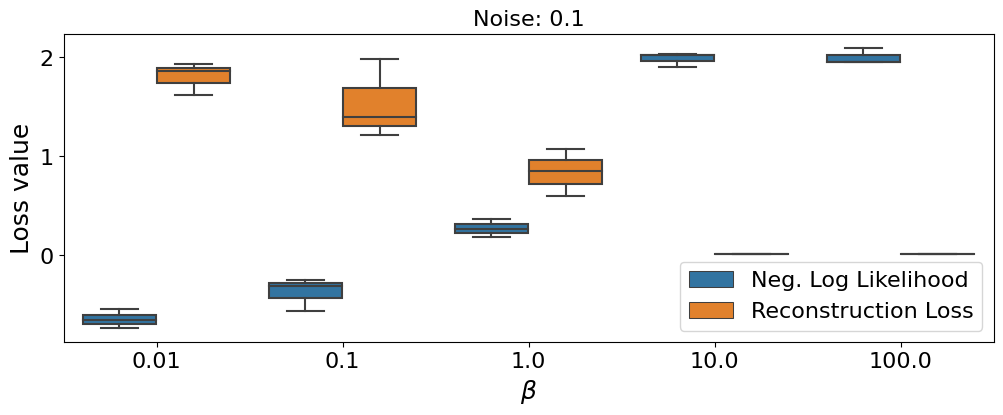

In [16]:
df_filtered = df.query('noise==0.1')
df_violin = df_filtered[['reconstruction_weights','nll','noisy_reconstruction','noise']].query(' | '.join(['reconstruction_weights == ' + str(x) for x in [0.01,0.05,0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10,100]]))
df_violin = df_violin.rename(columns={'noisy_reconstruction': 'Reconstruction Loss', 'nll':'Neg. Log Likelihood'})
df_violin = pd.melt(df_violin, id_vars=['noise','reconstruction_weights'], value_vars=['Neg. Log Likelihood','Reconstruction Loss'])

plt.figure(figsize=(12,4))
fig = sns.boxplot(data=df_violin, x='reconstruction_weights', y='value', hue='variable')
fig.set_xlabel(r'$\beta$', fontsize=18)
fig.set_ylabel('Loss value', fontsize=18)
fig.legend_.set_title(None)
fig.legend(fontsize=16)
plt.yticks([0,1,2])
fig.tick_params(labelsize=16)
plt.title('Noise: 0.1', fontsize=16)

Text(0.5, 1.0, 'Noise: 0.1')

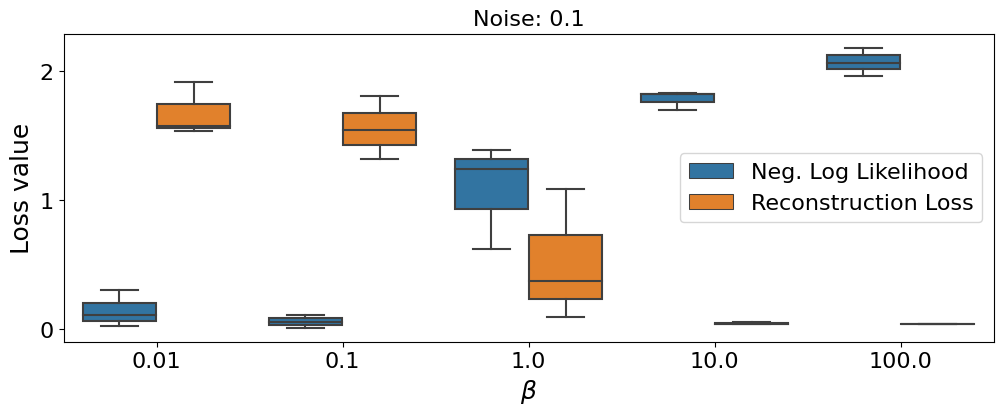

In [17]:
df_filtered = df.query('noise==0.2')
df_violin = df_filtered[['reconstruction_weights','nll','noisy_reconstruction','noise']].query(' | '.join(['reconstruction_weights == ' + str(x) for x in [0.01,0.05,0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10,100]]))
df_violin = df_violin.rename(columns={'noisy_reconstruction': 'Reconstruction Loss', 'nll':'Neg. Log Likelihood'})
df_violin = pd.melt(df_violin, id_vars=['noise','reconstruction_weights'], value_vars=['Neg. Log Likelihood','Reconstruction Loss'])

plt.figure(figsize=(12,4))
fig = sns.boxplot(data=df_violin, x='reconstruction_weights', y='value', hue='variable')
fig.set_xlabel(r'$\beta$', fontsize=18)
fig.set_ylabel('Loss value', fontsize=18)
fig.legend_.set_title(None)
fig.legend(fontsize=16)
plt.yticks([0,1,2])
fig.tick_params(labelsize=16)
plt.title('Noise: 0.1', fontsize=16)

## Plot latent codes

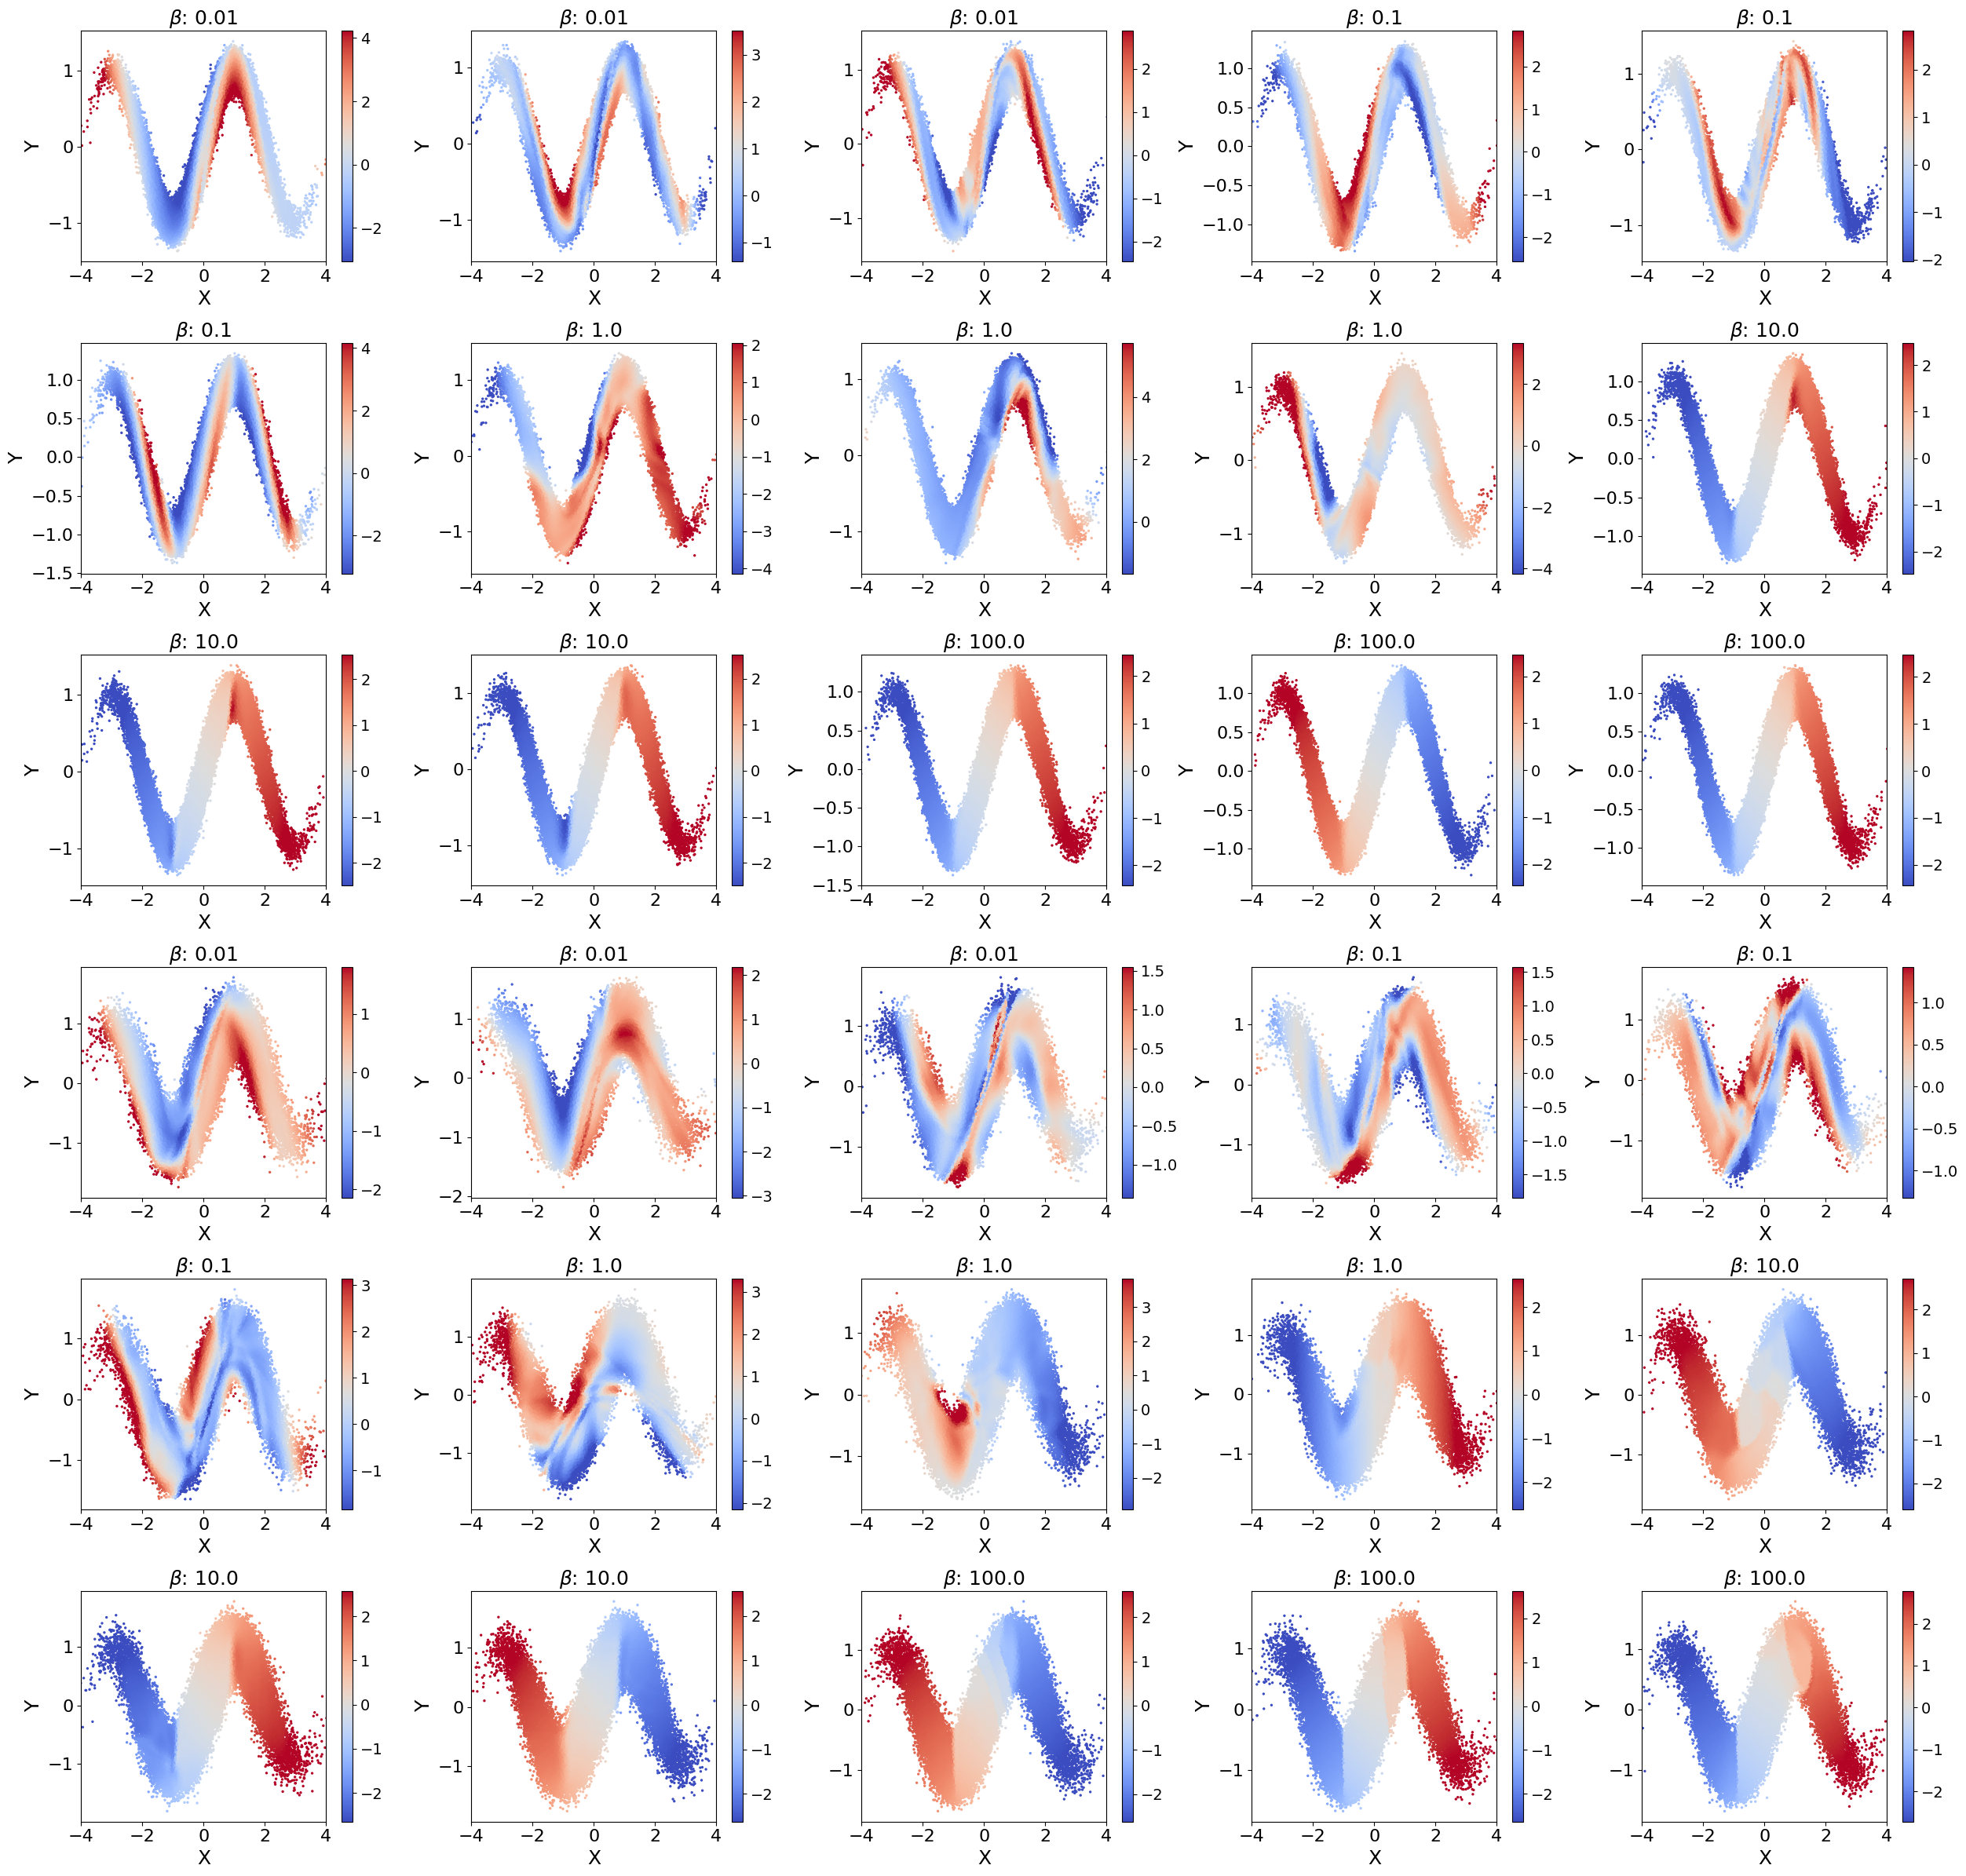

In [18]:
fig = plot_x_with_latent_codes(df, rc_levels, noise_levels, [0,1,2], switch_axis=True, print_titles=True, with_countours=False, fill=False, levels=15, dist=0.4, xlim=[-4,4],cmap='coolwarm')
plt.show()

/home/l/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


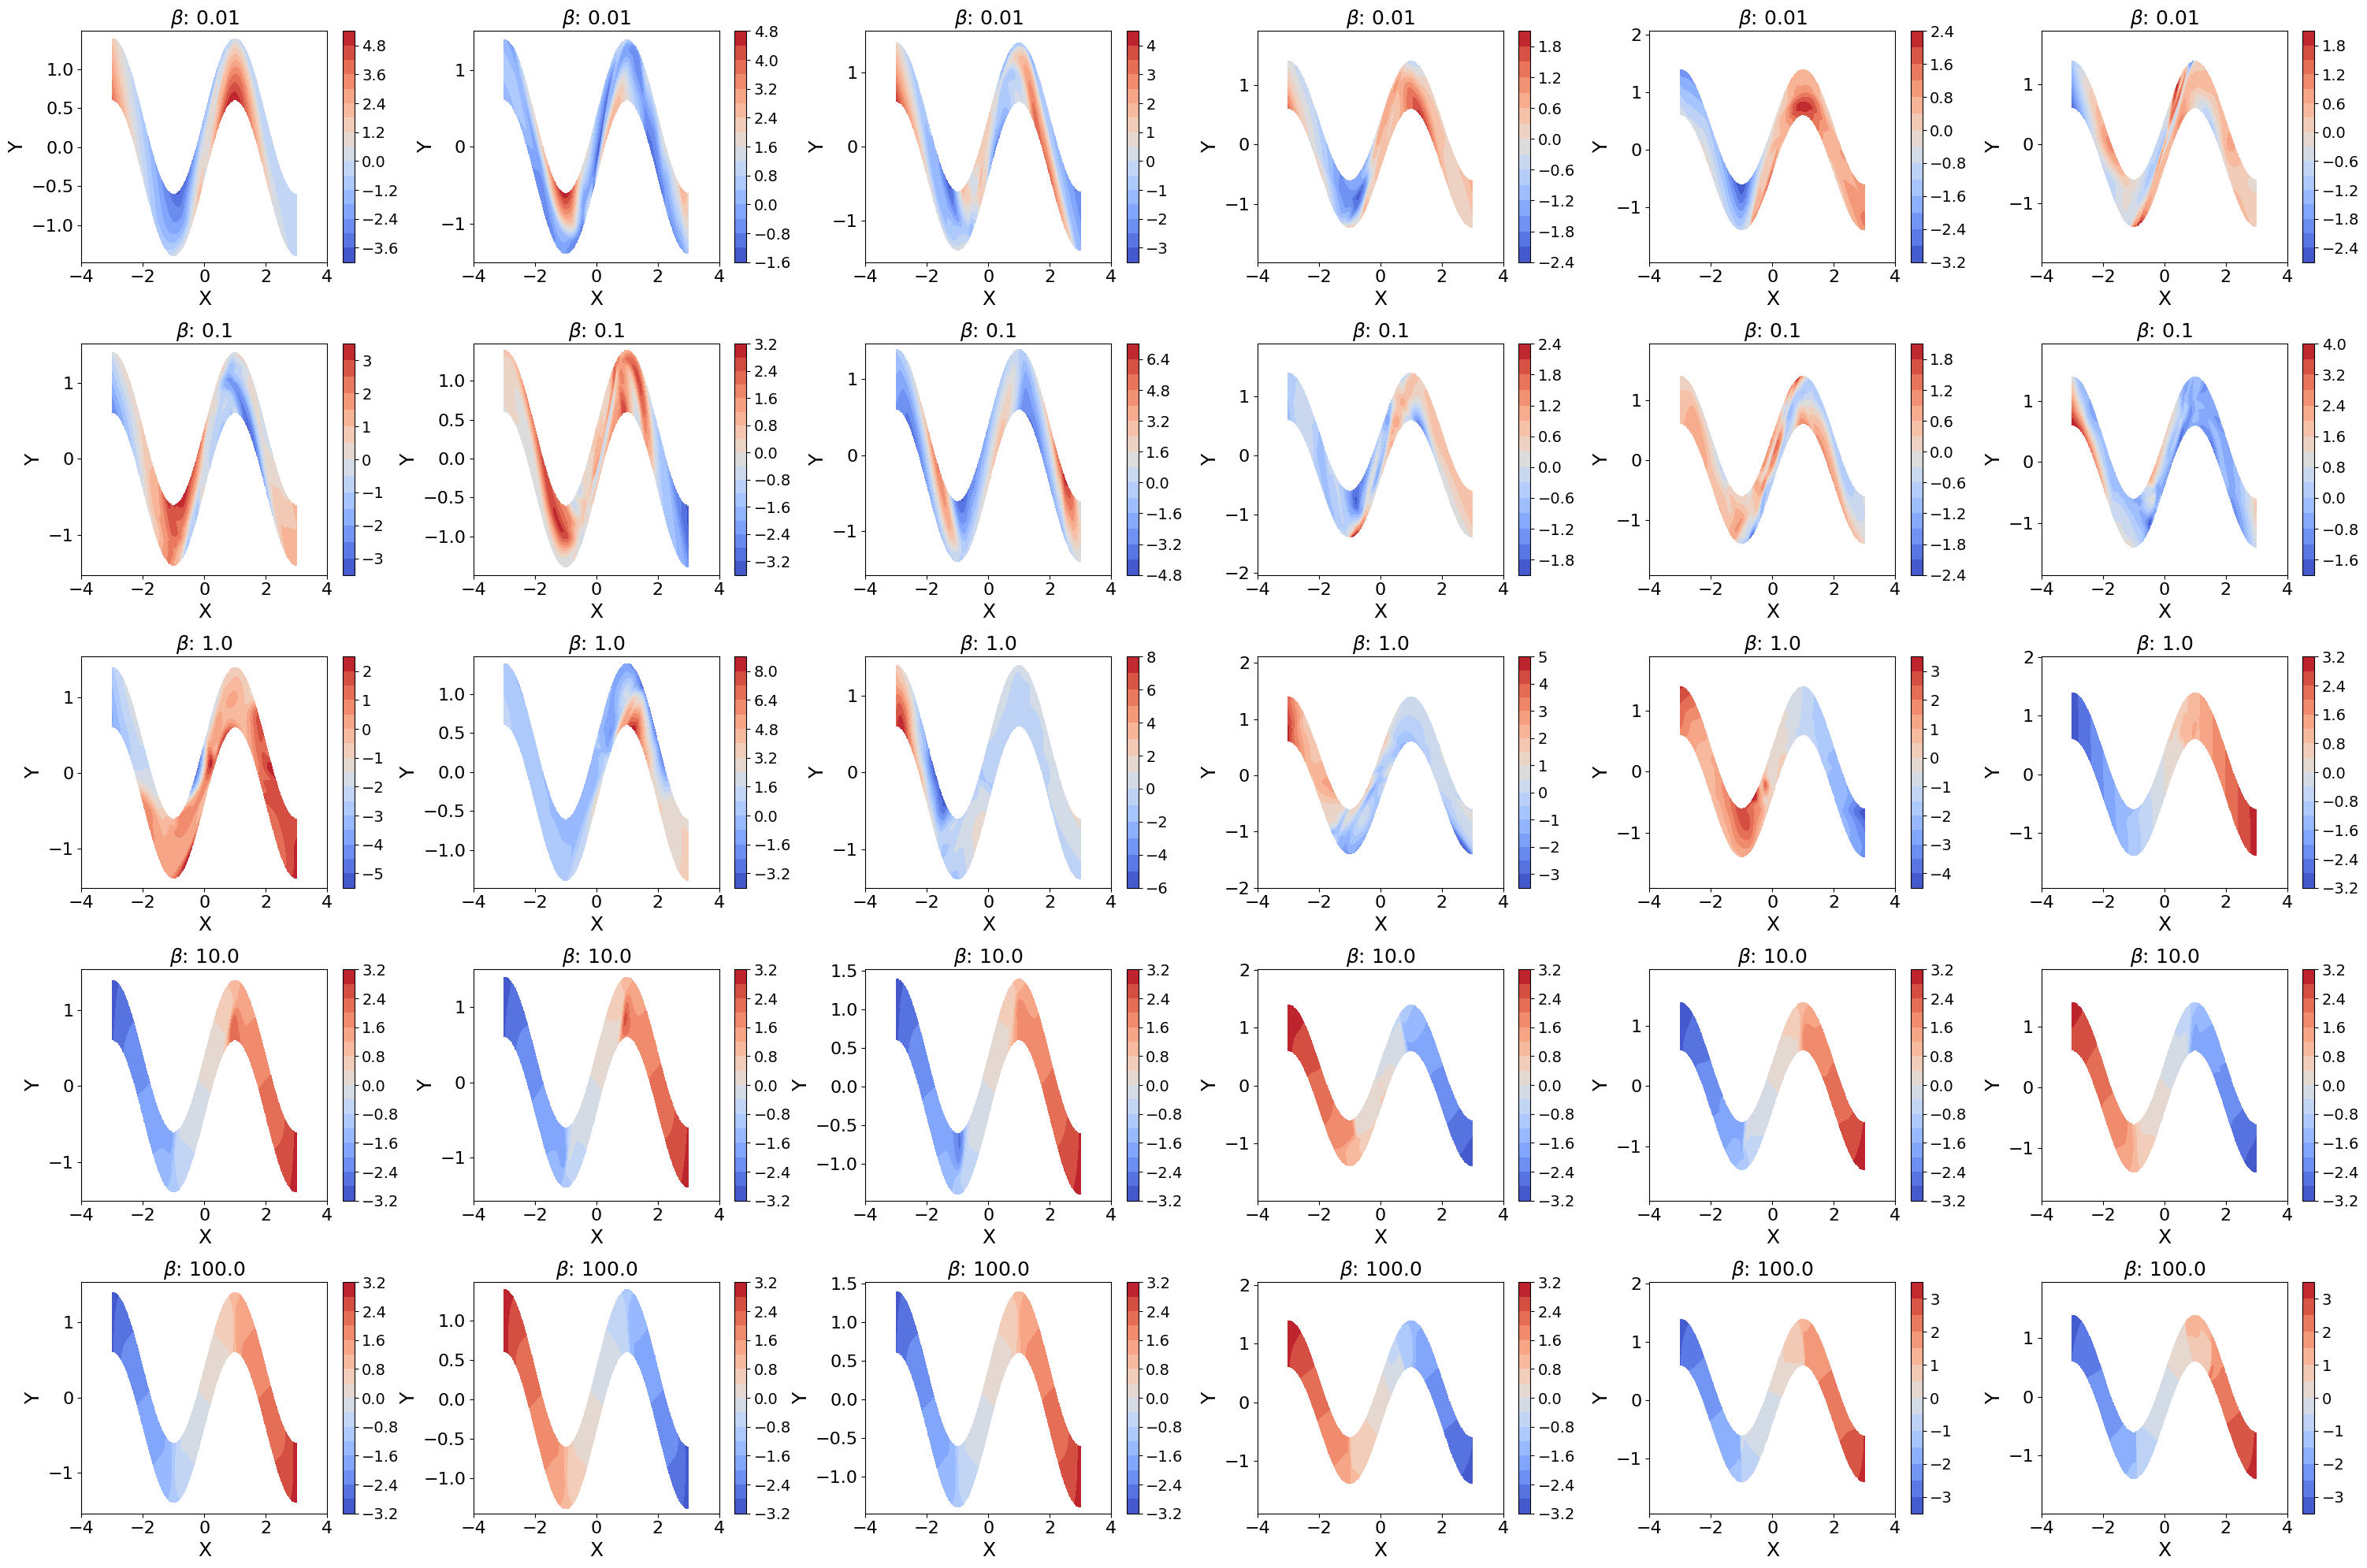

In [19]:
fig = plot_x_with_latent_codes(df, rc_levels, noise_levels, [0,1,2], print_titles=True, print_scatter=False, with_countours=True, fill=True, levels=15, dist=0.4, xlim=[-4,4], cmap='coolwarm')
plt.show()